### The idea through this module is to find the optimal conditions (Wt%, Salt Conc. and Temperature) for the synthesis of a Laponite System with a given n , tg and s by sampling from the input space posterior distribution using the Metropolis Hastings Algorithm.The main advantage of such an approach over the fixed optimisation is that the user is made aware of different optimal conditions that yield the same output and this may be helpful if one of them may be easier to achieve synthetically.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import numpy as np
import torch
import gpytorch
from sklearn.preprocessing import *

In [36]:
df=pd.read_excel("UGP_Data.xlsx",sheet_name="Data_Model")

In [37]:
df.head()

,wt%,salt [mM],tan delta,delta,Temp,n,noise_n,FD,noise_fd,tg,log_tg,noise_tg,time [h],G',"G""",avg_noise_tg,noise_log_tg,S,log_S,noise_S
0,4.0,3.0,0.247,0.242153,30,0.154159,NaN,2.364575,NaN,30.430000,1.483302,--,--,39.693475,10.931510,28.928000,1.461318,40.751042,1.610139,NaN
1,3.8,3.0,0.275,0.268366,30,0.170847,NaN,2.349030,NaN,34.931000,1.543211,--,--,28.629795,8.905488,28.928000,1.461318,29.501316,1.469841,NaN
2,4.0,0.0,0.287,0.279488,30,0.177928,0.000883,2.342379,0.000831,282.000000,2.450249,0,4.7,53.635362,16.428162,28.928000,1.461318,55.356978,1.743172,21.773822
3,3.8,0.0,0.310,0.300606,30,0.191372,0.00145,2.329658,0.00138,563.333333,2.750765,13.058333,9.388889,39.357156,13.865581,13.058333,1.115888,40.747212,1.610098,12.38365
4,3.6,0.0,0.336,0.324149,30,0.206359,0.000857,2.315331,0.000824,649.033333,2.812267,48.841667,10.817222,31.042231,10.967994,48.841667,1.688790,32.253468,1.508576,9.100433


In [38]:
dfx=df[["wt%","salt [mM]","Temp"]]
dfy=df[["n","log_tg","log_S"]]

In [39]:
X=np.array(dfx)
y=np.array(dfy)
outputs=["n","log_tg","log_S"]

In [40]:
sc_X=StandardScaler()
X_sc=sc_X.fit_transform(X)
wt_mean=sc_X.mean_[0]
sc_mean=sc_X.mean_[1]
wt_std=np.sqrt(sc_X.var_[0])
sc_std=np.sqrt(sc_X.var_[1])

In [41]:
wt_mean

2.582608695652174

In [42]:
wt_std

0.7422950157175838

In [43]:
sc_mean

3.243478260869565

In [44]:
sc_std

2.2867911991823484

In [45]:
sc_y=StandardScaler()
y_sc=sc_y.fit_transform(y)

Training Set X 


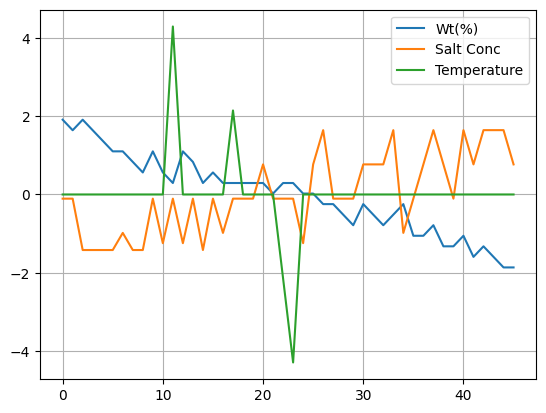

In [46]:
print("Training Set X ")
plt.plot(X_sc)
plt.legend(["Wt(%)","Salt Conc","Temperature"])
plt.grid()

Training Set y 


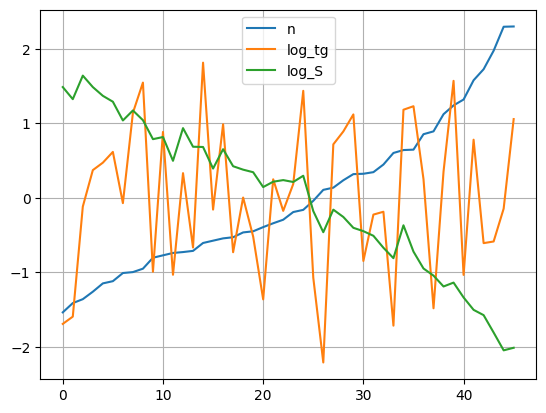

In [47]:
print("Training Set y ")
plt.plot(y_sc)
plt.legend(["n","log_tg","log_S"])
plt.grid()

In [48]:
X_sc=torch.tensor(X_sc)
y_sc=torch.tensor(y_sc)

Here we mention the target y values we are interested in obtaining

In [49]:
n=0.2
log_tg=np.log10(300)
log_s=np.log10(30)
y_req=np.reshape(np.array([n,log_tg,log_s]),(1,-1))
y_req_sc=sc_y.transform(y_req)

In [50]:
log_tg

2.4771212547196626

In [51]:
log_s

1.4771212547196624

### Using the MOGP Joint Inference using RBF

In [52]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

In [53]:
X_32_sc=X_sc.to(torch.float32)
y_32_sc=y_sc.to(torch.float32)

In [54]:
model_mogp = MultitaskGPModel(X_32_sc,y_32_sc,likelihood_mogp)

In [55]:
training_iterations =50


# Find optimal model hyperparameters
model_mogp.train()
likelihood_mogp.train()

# Use the adam optimizer
optimizer_mogp = torch.optim.Adam(model_mogp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll_mogp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_mogp, model_mogp)

for i in range(training_iterations):
    optimizer_mogp.zero_grad()
    output_mogp = model_mogp(X_32_sc)
    loss_mogp = -mll_mogp(output_mogp,y_32_sc)
    loss_mogp.backward()
    optimizer_mogp.step()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [56]:
mean_params = model_mogp.mean_module.state_dict()
covar_params = model_mogp.covar_module.task_covar_module.covar_matrix.numpy()

In [57]:
print('Mean Parameters of the trained MOGP Model')
print(mean_params)
print('Covarinace Parameters of the trained MOGP Model')
print(covar_params)

Mean Parameters of the trained MOGP Model
OrderedDict([('base_means.0.raw_constant', tensor(0.4832)), ('base_means.1.raw_constant', tensor(-0.3487)), ('base_means.2.raw_constant', tensor(-0.3396))])
Covarinace Parameters of the trained MOGP Model
[[ 2.629897    0.98471326 -2.3477154 ]
 [ 0.98471326  3.264585   -0.8892917 ]
 [-2.3477154  -0.8892917   2.1585767 ]]


In [58]:
def ymodelpred(x):
    #Appending temperature
    xmodel=np.append(x,[0])
    xmodel=np.reshape(xmodel,(1,-1))
    xmodel=torch.tensor(xmodel)
    xmodel=xmodel.to(torch.float32)
    # Set into eval mode
    model_mogp.eval()
    likelihood_mogp.eval()
    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions_mogp = likelihood_mogp(model_mogp(xmodel))
        mean_mogp = predictions_mogp.mean
        lower_mogp, upper_mogp = predictions_mogp.confidence_region()
    return mean_mogp

# def ymodelpred_custom(x):
#     # Set into eval mode
#     model_mogp.eval()
#     likelihood_mogp.eval()
#     # Make predictions
#     with torch.no_grad(), gpytorch.settings.fast_pred_var():
#         predictions_mogp = likelihood_mogp(model_mogp(x))
#         mean_mogp = predictions_mogp.mean
#         lower_mogp, upper_mogp = predictions_mogp.confidence_region()
#     return lower_mogp,mean_mogp,upper_mogp
    
def probdist(x, yobs=y_req_sc, s2=0.2):
    """
    posterior distribution p(x|y) = Lik * prior
    in practice, we can remove all constant prefactors [0.25, 1/(2*np.pi*s2)] since
    acceptance criterion only depends on ratios
    """
    if x[0] < -wt_mean/wt_std or x[0] > 2. or x[1]<-sc_mean/sc_std or x[1] >2.:
        return 0.
    else:
        Lik = 1/(2*np.pi*s2) * np.exp(-0.5*(np.linalg.norm((yobs - np.array(ymodelpred(x))),2)**2)/s2)
        return Lik * 0.25*0.25
    
# def probdist_custom(x, yobs=y_req_sc):
#     """
#     posterior distribution p(x|y) = Lik * prior
#     in practice, we can remove all constant prefactors [0.25, 1/(2*np.pi*s2)] since
#     acceptance criterion only depends on ratios
#     """
#     lower,mean,upper=ymodelpred(x)
#     s=(upper-lower)/2
#     s2=s**2
#     if x[0] < -2. or x[0] > 2. or x[1]<-2. or x[1] >2.:
#         return 0.
#     else:
#         Lik = 1/(2*np.pi*s2) * np.exp(-0.5*(yobs - mean)**2/s2)
#         return Lik * 0.25*0.25
      
def proposal(xc, delta):
    """"""
    return np.random.normal(xc, delta)

def accept(xc, xn, f):
    """
    Metropolis criterion
    """

    acc   = False
    ratio = f(xn)/f(xc)
    
    if ratio > 1.:
        acc = True
    elif np.random.rand() < ratio:
        acc = True
    
    return acc

def metropolisMCMC(nmcs,burnin, delta=[0.1,0.1], x0=[0.0,0.0]):
    x     = np.zeros((nmcs-burnin,2))
    xc    = np.copy(x0)
    nSucc = 0

    for icms in range(burnin):
        xn=proposal(xc,delta)
        if(accept(xc, xn, probdist)):
            xc = np.copy(xn)
            nSucc += 1    
    for imcs in range(nmcs-burnin):

        x[imcs] = xc
        
        xn = proposal(xc, delta)
        
        if(accept(xc, xn, probdist)):
            xc = np.copy(xn)
            nSucc += 1
        
    return x, float(nSucc)/nmcs

def plotSamples(x):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

    ax1.plot(x[:,0],'-')
    ax1.set_xlabel('MCS',fontsize=18)
    ax1.set_ylabel('Scaled Weight %',fontsize=18)

    ax2.plot(x[:,1],'-')
    ax2.set_xlabel('MCS',fontsize=18)
    ax2.set_ylabel('Scaled Salt Concn.',fontsize=18)

    # import plotly.graph_objects as go
    # # Create a 2D histogram
    # hist, x_edges, y_edges = np.histogram2d(x[:,0],x[:,1] , bins=20)

    # # Construct the 3D surface plot
    # x_mid = 0.5 * (x_edges[1:] + x_edges[:-1])
    # y_mid = 0.5 * (y_edges[1:] + y_edges[:-1])
    # x_mesh, y_mesh = np.meshgrid(x_mid, y_mid)
    # z = hist.T  # Transpose due to the way histogram2d outputs the data
    # # Create the figure
    # fig = go.Figure(data=[go.Surface(z=z, x=x_mesh, y=y_mesh)])

    # # Update layout for better visualization
    # fig.update_layout(
    #     title='Histogram of Sampled Data using M-H',
    #     scene=dict(
    #         xaxis_title='Scaled Weight %',
    #         yaxis_title='Scaled Salt Conc.',
    #         zaxis_title='Count'
    #     )
    # )
    # # Show the plot
    # fig.show()

In [59]:
x, accRatio = metropolisMCMC(nmcs=80000,burnin=100, delta=[0.25,0.25], x0=[-1.46,0.0])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


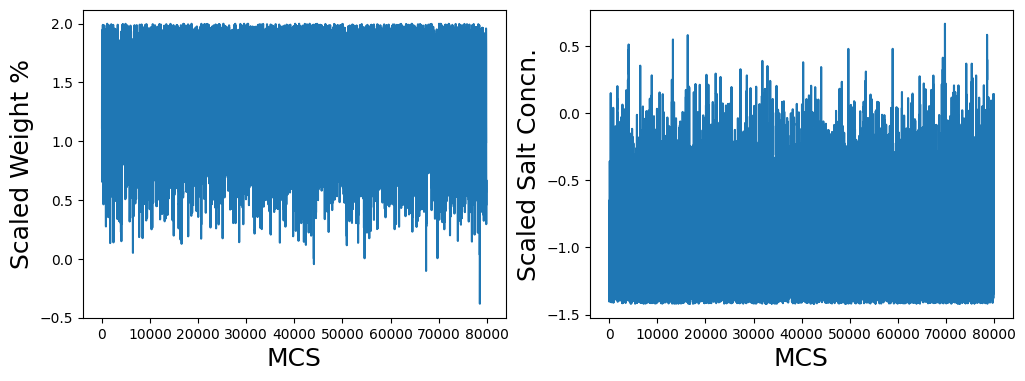

In [60]:
plotSamples(x)

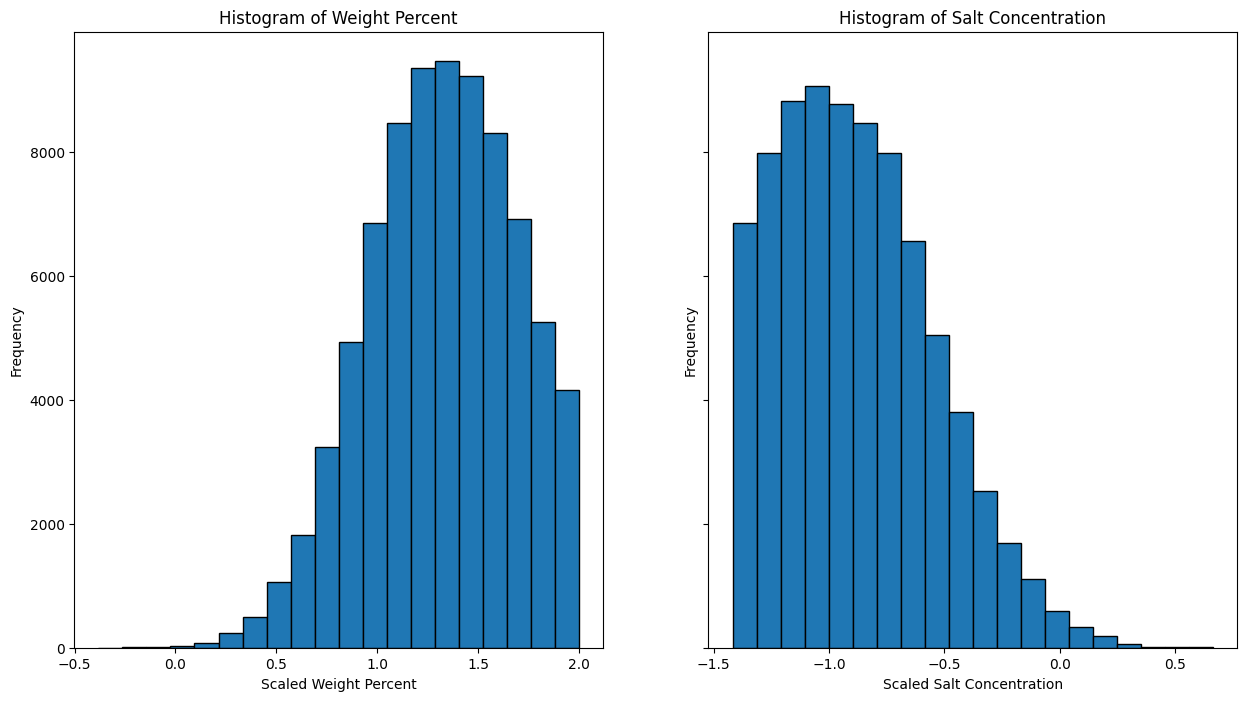

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(15,8),sharey=True)
#Scaled Weight Percent
axs[0].hist(x[:,0], bins=20, edgecolor='black')
axs[0].set_title('Histogram of Weight Percent')
axs[0].set_xlabel('Scaled Weight Percent')
axs[0].set_ylabel('Frequency')

axs[1].hist(x[:,1], bins=20, edgecolor='black')
axs[1].set_title('Histogram of Salt Concentration')
axs[1].set_xlabel('Scaled Salt Concentration')
axs[1].set_ylabel('Frequency')

# Show the plot
plt.show()


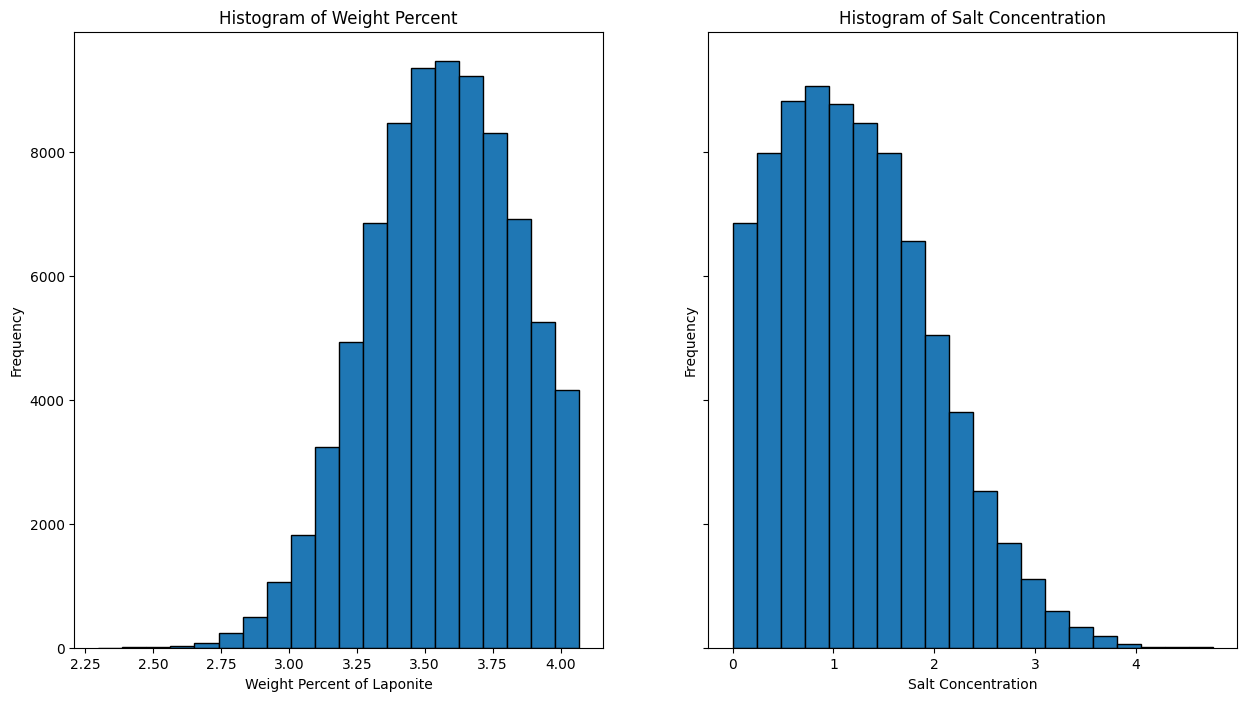

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(15,8),sharey=True)
#Scaled Weight Percent
axs[0].hist(x[:,0]*wt_std+wt_mean, bins=20, edgecolor='black')
axs[0].set_title('Histogram of Weight Percent')
axs[0].set_xlabel('Weight Percent of Laponite')
axs[0].set_ylabel('Frequency')

axs[1].hist(x[:,1]*sc_std+sc_mean, bins=20, edgecolor='black')
axs[1].set_title('Histogram of Salt Concentration')
axs[1].set_xlabel('Salt Concentration')
axs[1].set_ylabel('Frequency')

# Show the plot
plt.show()

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(x)
df[0]=df[0]*wt_std+wt_mean
df[0]=df[0].round(3)
df[1]=df[1]*sc_std+sc_mean
df[1]=df[1].round(3)
df

,0,1
0,3.411,1.216
1,3.640,1.152
2,3.640,1.152
3,3.524,0.843
4,3.524,0.843
...,...,...
79895,3.080,3.192
79896,3.080,3.192
79897,3.080,3.192
79898,2.927,3.562


In [64]:
d=np.array(df.value_counts())
df=df.drop_duplicates()
df['freq']=d

/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_4262/2693034368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['freq']=d


In [65]:
df

,0,1,freq
0,3.411,1.216,20
1,3.640,1.152,18
3,3.524,0.843,15
5,3.534,0.891,14
6,3.580,0.514,13
...,...,...,...
79888,2.801,2.094,1
79890,2.875,2.417,1
79892,2.866,2.416,1
79894,3.080,3.192,1


/var/folders/r7/2_r0cpxd4vz87rt3d7z1b4fc0000gn/T/ipykernel_4262/456639933.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = df.iloc[0:10].pivot(1,0,'freq')


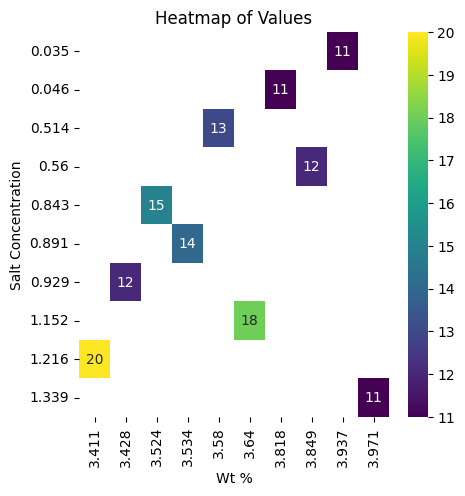

In [66]:
# Pivot the DataFrame to create a matrix
pivot_table = df.iloc[0:10].pivot(1,0,'freq')

# Create the heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True)

# Add title and labels
plt.title('Heatmap of Values')
plt.xlabel('Wt %')
plt.ylabel('Salt Concentration')

# Show the plot
plt.show()

In [67]:
optim_cond1=[df.iloc[0][0:2].to_numpy(),30]
print(optim_cond1)

[array([3.411, 1.216]), 30]


In [68]:
optim_cond2=[df.iloc[1][0:2].to_numpy(),30]
print(optim_cond2)

[array([3.64 , 1.152]), 30]
